# Feature Selection Pipeline

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import MinMaxScaler
from selective_RF import selectiveRF
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

### - Dataset Loader (Load Entire Dataset or Make it here)

In [2]:
df0 = pd.read_csv('/home/juan/Documents/Master_Project/data/process/dataset-09-03.csv')
dff = pd.read_csv('/home/juan/Documents/Master_Project/data/interim/forces.csv')
dff = dff.iloc[:,1:]
df =  pd.merge(df0, dff, on='Folder', how='inner')
df = df[[col for col in df.columns if col not in ['Folder', 'QM/MM SP Barrier']] + ['Folder', 'QM/MM SP Barrier']]
df.head()

,nBonds,nBondsD,nBonds2,nBondsT,nBondsM,pubchemcomplexity,pubchemhbondacceptor,pubchemhbonddonor,pubchemrotbon,pubchemlogp,...,box_77,box_78,box_79,box_80,uff_energy,internal_vdw_energy,torsion_energy,torsion_angle_energy,Folder,QM/MM SP Barrier
0,23,1,11,0,11,0.39820,5,2,4,0.39820,...,0.0,0.0,0.0,0.0,77.872649,-4.140895,14.909536,0.463553,mol_134810,29.71
1,26,0,14,0,12,3.35790,4,0,3,3.35790,...,0.0,0.0,0.0,0.0,55.720345,-4.359442,11.850982,0.002330,mol_147462,28.33
2,27,2,5,0,20,1.33280,8,2,3,1.33280,...,0.0,0.0,0.0,0.0,123.076457,-3.610614,3.146857,1.698714,mol_152261,27.40
3,27,2,14,0,11,1.79150,6,1,7,1.79150,...,0.0,0.0,0.0,0.0,73.997554,-6.877329,5.901305,5.973538,mol_22419,28.28
4,24,1,16,1,6,1.46888,6,0,6,1.46888,...,0.0,0.0,0.0,0.0,45.209392,-6.980556,32.468455,4.764511,mol_469,22.72


In [2]:
df = pd.read_csv('/home/juan/Documents/Master_Project/data/process/final_selection/All_feats_newC_hp_atoms.csv')
df=df.iloc[:,1:]
x = df.drop(columns=['Folder','QM/MM SP Barrier'])
y = df['QM/MM SP Barrier']


In [3]:
df_forces = pd.read_csv('/home/juan/Documents/Master_Project/data/interim/forces_no_optimize.csv')
df_forces = df_forces.iloc[:,1:]
df_forces.head()

,Folder,uff_energy,internal_vdw_energy,torsion_energy,torsion_angle_energy
0,mol_134810,104.293073,2.925351,12.268261,1.176219
1,mol_147462,77.718378,-4.432160,21.626627,0.178048
2,mol_152261,158.675551,-2.885005,10.689743,0.083856
3,mol_22419,94.836176,-5.104365,6.601106,8.052565
4,mol_469,67.275734,-3.150597,9.767127,4.792619


In [4]:
columns_to_extract = ['uff_energy','internal_vdw_energy','torsion_energy','torsion_angle_energy']


# Step 1: Extracting Columns from df
columns_to_keep = df.drop(columns=columns_to_extract)

df = pd.merge(columns_to_keep, df_forces, on='Folder', how='left')


In [5]:
df.head()

,nBondsD,nBonds2,nBondsT,nBondsM,pubchemcomplexity,pubchemhbondacceptor,pubchemhbonddonor,pubchemrotbon,pubchemlogp,pubchemmass,...,hp_Atom_35,hp_Atom_36,hp_Atom_37,hp_Atom_38,Folder,QM/MM SP Barrier,uff_energy,internal_vdw_energy,torsion_energy,torsion_angle_energy
0,1,11,0,11,0.39820,5,2,4,0.39820,285.371,...,0.0,0.0,0.0,0.0,mol_134810,29.71,104.293073,2.925351,12.268261,1.176219
1,0,14,0,12,3.35790,4,0,3,3.35790,309.413,...,0.0,0.0,0.0,0.0,mol_147462,28.33,77.718378,-4.432160,21.626627,0.178048
2,2,14,0,11,1.79150,6,1,7,1.79150,340.427,...,0.0,0.0,0.0,0.0,mol_22419,28.28,94.836176,-5.104365,6.601106,8.052565
3,1,16,1,6,1.46888,6,0,6,1.46888,316.405,...,0.0,0.0,0.0,0.0,mol_469,22.72,67.275734,-3.150597,9.767127,4.792619
4,1,12,0,6,-0.04998,4,3,2,-0.04998,252.313,...,0.0,0.0,0.0,0.0,mol_67286,25.81,53.228547,-2.510429,24.631267,0.147438


### - Correlation Matrix

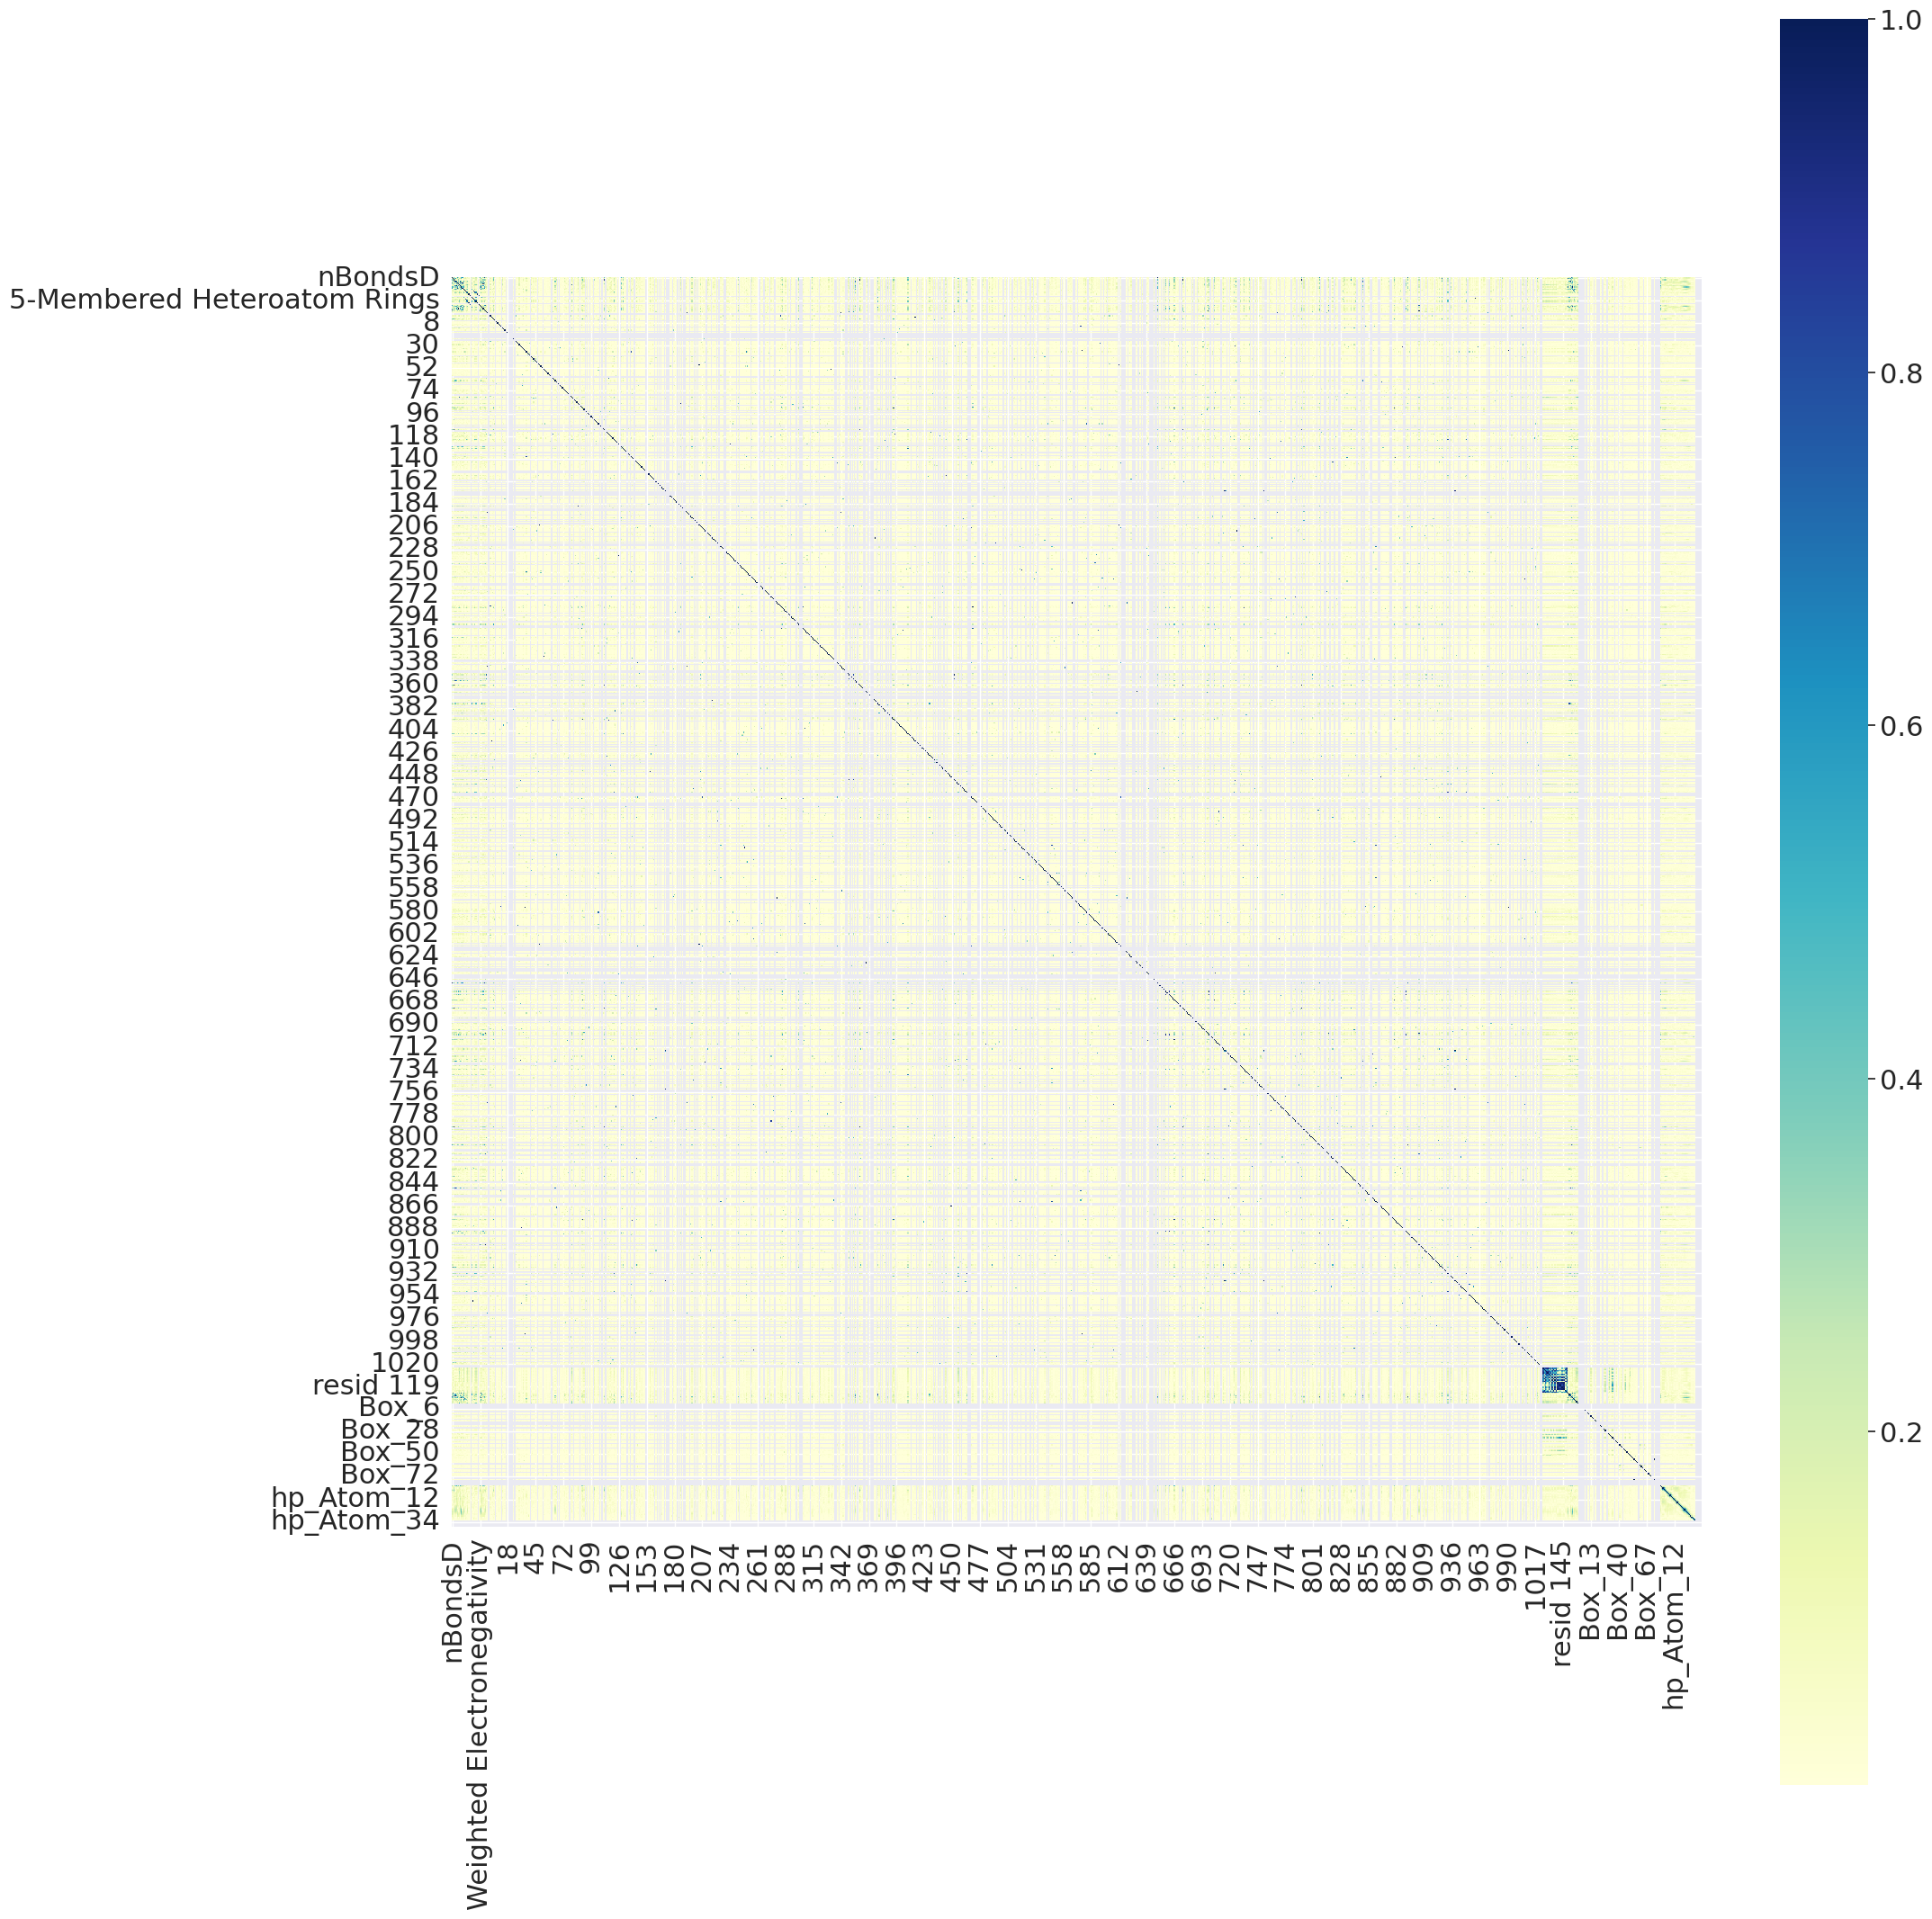

In [6]:
corr_matrix = x.corr(method = 'spearman').abs()

# Set font scale
sns.set(font_scale = 2)

# Set the figure size
f, ax = plt.subplots(figsize=(23, 23))

# Make heatmap
sns.heatmap(corr_matrix, cmap= 'YlGnBu', square=True, ax = ax)

# Tight layout
f.tight_layout()

In [7]:
# Calculate correlation matrix
corr_matrix = x.corr(method='spearman').abs()

# Filter correlations above 0.3
corr_above_threshold = corr_matrix[corr_matrix > 0.3]

# Find the most correlated features
most_correlated_features = (corr_above_threshold
                            .stack()  # Convert to stacked format for sorting
                            .sort_values(ascending=False)  # Sort by correlation value
                            .reset_index()  # Reset index to access columns
                            .rename(columns={0: 'correlation'})  # Rename the correlation column
                            .query('level_0 != level_1'))  # Exclude self-correlations
# Remove duplicates by considering only one direction of the correlation
most_correlated_features_unique = (most_correlated_features
                                   .loc[most_correlated_features['level_0'] < most_correlated_features['level_1']])

# Display the most correlated features without duplicates
print("Most correlated features without duplicates:")
print(most_correlated_features_unique.head(10))

Most correlated features without duplicates:
    level_0 level_1  correlation
16      449     867          1.0
148     576     991          1.0
205     204     612          1.0
207     204      49          1.0
226     210     727          1.0
242     217     375          1.0
259     126     234          1.0
300     366     630          1.0
301     332      53          1.0
393     280     567          1.0


In [8]:
from scipy.cluster import hierarchy

# Replace missing values with a placeholder (e.g., zero) or impute them
corr_matrix_filled = corr_matrix.fillna(0)  # Replace NaNs with zero

# Check if the correlation matrix contains any non-finite values
if not np.all(np.isfinite(corr_matrix_filled)):
    raise ValueError("The correlation matrix contains non-finite values.")

# Perform hierarchical clustering based on the correlation matrix
linkage = hierarchy.linkage(corr_matrix_filled, method='average')

# Define the number of clusters
num_clusters = 6

# Perform clustering to obtain cluster assignments
clusters = hierarchy.fcluster(linkage, num_clusters, criterion='maxclust')

# Create a dictionary to store the features in each cluster
clustered_features = {}
for feature, cluster in zip(x.columns, clusters):
    if cluster not in clustered_features:
        clustered_features[cluster] = [feature]
    else:
        clustered_features[cluster].append(feature)

# Print the features in each cluster
for cluster, features in clustered_features.items():
    print(f"Cluster {cluster}: {features}")



Cluster 5: ['nBondsD', 'pubchemhbondacceptor', 'pubchemtsa', 'O', '128', '197', '314', '650', '807', '893', 'amide_bonds']
Cluster 4: ['nBonds2', 'nBondsM', 'pubchemcomplexity', 'pubchemlogp', 'pubchemmass', 'nRing', 'C', '64', '356', '726', '849', '926', 'atom_number', 'aromatic_rings', 'heavy_atoms', 'uff_energy', 'internal_vdw_energy', 'Total Charge']
Cluster 6: ['nBondsT', 'pubchemhbonddonor', 'Weighted Electronegativity', 'H', 'F', '4', '91', '112', '130', '285', '301', '360', '393', '407', '658', '661', '666', '674', '699', '700', '705', '734', '739', '790', '816', '838', '880', '891', '904']
Cluster 3: ['pubchemrotbon', 'n3Ring', 'n4Ring', 'n5Ring', 'n6Ring', 'n7Ring', 'n8Ring', 'nMoreRing', 'Total Heteroatom Rings', '3-Membered Heteroatom Rings', '4-Membered Heteroatom Rings', '5-Membered Heteroatom Rings', '6-Membered Heteroatom Rings', '7-Membered Heteroatom Rings', '12-Membered Heteroatom Rings', 'More than 12-Membered Heteroatom Rings', 'N', 'S', 'P', 'Br', '0', '1', '2', '

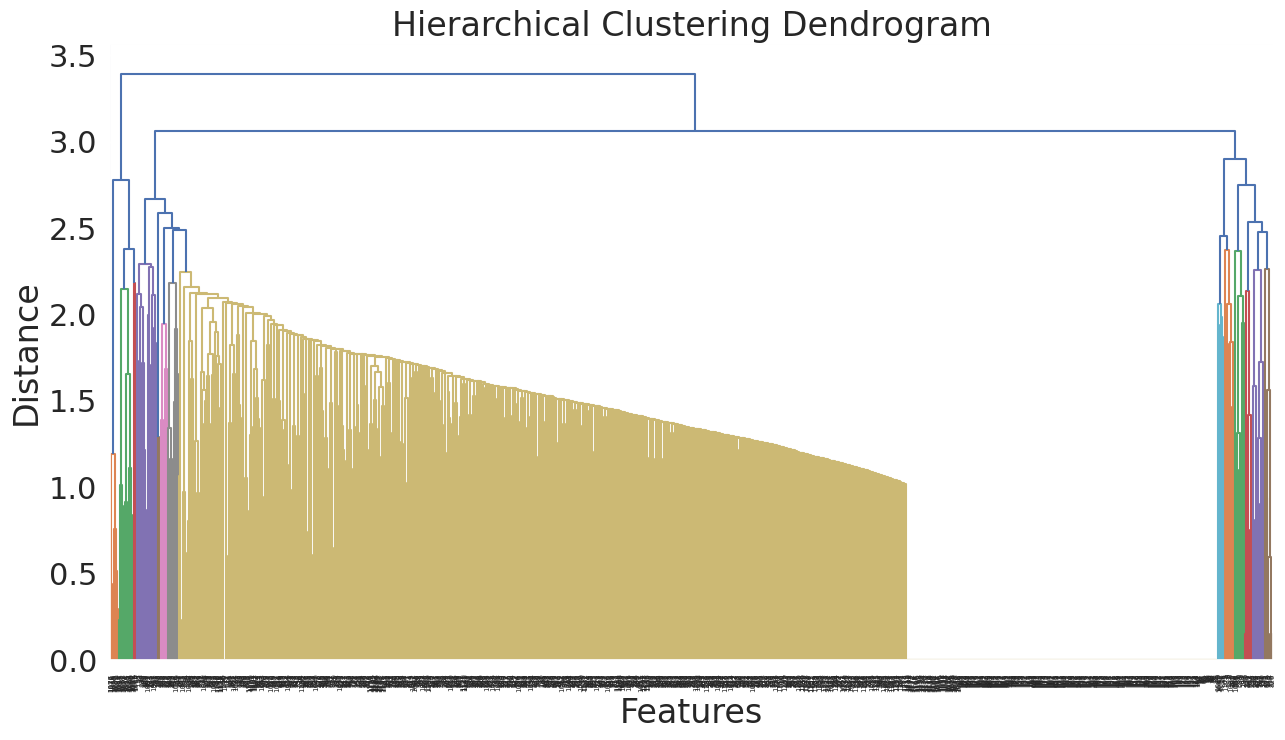

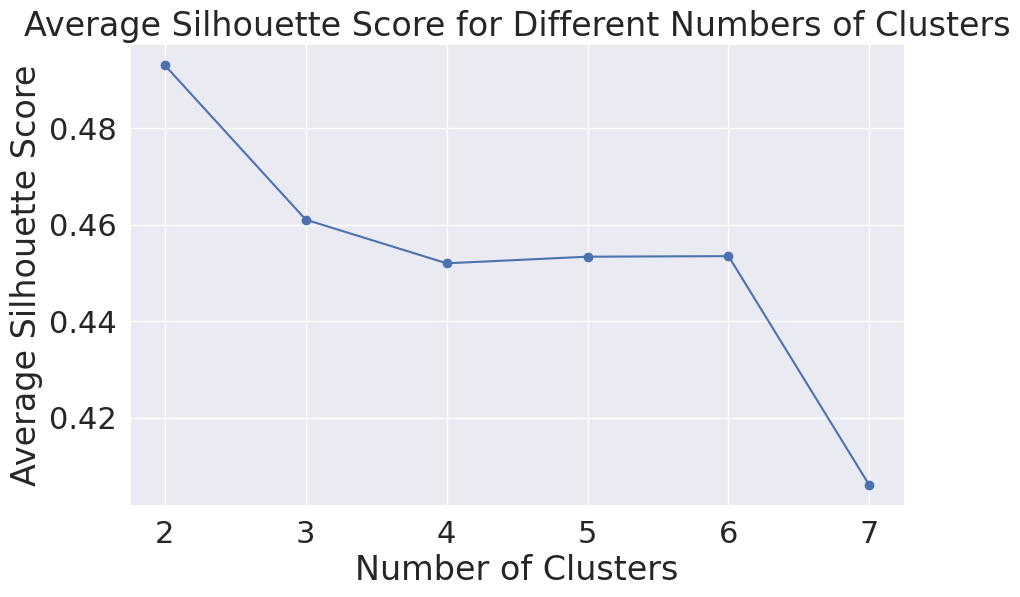

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Replace missing values with a placeholder (e.g., zero) or impute them
corr_matrix_filled = corr_matrix.fillna(0)  # Replace NaNs with zero

# Perform hierarchical clustering based on the correlation matrix
linkage_matrix = linkage(corr_matrix_filled, method='average')

# Visualize the dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix)
plt.xlabel('Features')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

# Evaluate silhouette score for different numbers of clusters
silhouette_scores = []
max_clusters = 7
for num_clusters in range(2, max_clusters + 1):
    clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')
    silhouette_avg = silhouette_score(corr_matrix_filled, clusters)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Average Silhouette Score for Different Numbers of Clusters')
plt.grid(True)
plt.show()


#### - Correlation with target variable

In [10]:

# Calculate correlation coefficients between Y and each predictor variable in X
correlation_matrix = x.corrwith(y)

# Find the absolute values of correlation coefficients
abs_correlation = correlation_matrix.abs()

# Sort the absolute correlation values in descending order
sorted_correlation = abs_correlation.sort_values(ascending=False)
correlated_variables = sorted_correlation.dropna().index.tolist()
print(sorted_correlation.to_string())


Total Charge                              0.429521
666                                       0.261438
pubchemcomplexity                         0.259390
pubchemlogp                               0.259390
705                                       0.245352
880                                       0.218334
Weighted Electronegativity                0.212047
356                                       0.206770
O                                         0.201407
nBondsD                                   0.196277
650                                       0.192125
heavy_atoms                               0.186680
pubchemmass                               0.178377
91                                        0.177534
90                                        0.176370
H                                         0.176196
393                                       0.168512
pubchemtsa                                0.166996
807                                       0.165525
pubchemhbonddonor              

/home/juan/myenv/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/juan/myenv/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [11]:

# Convert Series to a list of tuples
sorted_correlation = sorted_correlation.items()

# Remove rows with NaN correlation coefficients
sorted_correlation = [item for item in sorted_correlation if not pd.isna(item[1])]

# Display the modified sorted_correlation list
print(sorted_correlation)

[('Total Charge', 0.4295212053118066), ('666', 0.26143816283067844), ('pubchemcomplexity', 0.25938989004928836), ('pubchemlogp', 0.25938989004928836), ('705', 0.24535184854785888), ('880', 0.2183338878916374), ('Weighted Electronegativity', 0.2120466582932117), ('356', 0.20677028911905898), ('O', 0.20140722204923117), ('nBondsD', 0.19627697488285822), ('650', 0.19212471114029706), ('heavy_atoms', 0.1866800943325741), ('pubchemmass', 0.17837728103241324), ('91', 0.17753365181959294), ('90', 0.1763699795827789), ('H', 0.17619619351700613), ('393', 0.16851203169693568), ('pubchemtsa', 0.16699630558679782), ('807', 0.16552502681192702), ('pubchemhbonddonor', 0.1620589294683858), ('314', 0.16192711417487812), ('nBondsM', 0.16086333571153572), ('aromatic_rings', 0.15795176813584674), ('amide_bonds', 0.1562972903678297), ('893', 0.15446316016497605), ('661', 0.15329174786355024), ('pubchemhbondacceptor', 0.14514137126039844), ('891', 0.14175072386249377), ('926', 0.13813863250065267), ('849',

## Features to Groups

In [12]:
all_features = df.columns.tolist()
print(f"There are {len(all_features)-2} features")

ch_density = []
MF = []
rings = []
bonds = []
pub = []
residues = []
various = []
targets_f = []
forces = []
hp_atoms = []

for column in df.columns:
    if column.isdigit():
        MF.append(column)
    elif column.startswith("box"):
        ch_density.append(column)
    elif "Ring" in column:
        rings.append(column)
    elif "Bond" in column:
        bonds.append(column)
    elif "pub" in column:
        pub.append(column)
    elif "resid" in column or "resname" in column:
        residues.append(column)
    elif "hp_Atom" in column:
        hp_atoms.append(column)
    elif "QM/MM" in column or "Folder" in column:
        targets_f.append(column)
    elif column in ["uff_energy", "internal_vdw_energy", "torsion_energy", "torsion_angle_energy"]:
        forces.append(column)
    else:
        various.append(column)


There are 1215 features


### Standarize Dataset

In [13]:
from sklearn.preprocessing import StandardScaler

def standardize_dataframe(dataframe, features_to_exclude):
    """
    Standardizes the numerical columns of a given DataFrame,
    excluding specified features.
    
    Parameters:
    - dataframe: pd.DataFrame
    - features_to_exclude: list
        List of feature names to exclude from standardization
    
    Returns:
    - pd.DataFrame: A DataFrame with standardized numerical columns.
    """
    # Initialize the scaler
    scaler = StandardScaler()
    
    # Select the numerical columns excluding features to exclude
    numerical_cols = dataframe.select_dtypes(include=['float64', 'int64']).columns
    numerical_cols = [col for col in numerical_cols if col not in features_to_exclude]
    
    # Standardize the data
    dataframe[numerical_cols] = scaler.fit_transform(dataframe[numerical_cols])
    
    return dataframe,scaler

# Define the features to exclude from standardization
features_to_exclude = MF + hp_atoms + ['Folder'] # Not necessary to add Folder!
df_copy = df.copy()
# Standardize the dataframe excluding 'MF' features
df_stand, ss = standardize_dataframe(df, features_to_exclude)
df_stand.head()


,nBondsD,nBonds2,nBondsT,nBondsM,pubchemcomplexity,pubchemhbondacceptor,pubchemhbonddonor,pubchemrotbon,pubchemlogp,pubchemmass,...,hp_Atom_35,hp_Atom_36,hp_Atom_37,hp_Atom_38,Folder,QM/MM SP Barrier,uff_energy,internal_vdw_energy,torsion_energy,torsion_angle_energy
0,-0.019627,-0.816714,-0.674144,0.643214,-0.416608,-0.118664,0.234516,0.521512,-0.416608,-0.417968,...,0.0,0.0,0.0,0.0,mol_134810,0.700025,0.050217,0.102576,-0.388174,-0.590562
1,-1.043795,0.101178,-0.674144,0.916599,1.815538,-0.916407,-1.774479,-0.175085,1.815538,0.181314,...,0.0,0.0,0.0,0.0,mol_147462,-0.001954,-0.267724,-0.111631,0.544287,-1.082024
2,1.004542,0.101178,-0.674144,0.643214,0.634191,0.679079,-0.769982,2.611303,0.634191,0.954384,...,0.0,0.0,0.0,0.0,mol_22419,-0.027388,-0.062926,-0.131201,-0.952845,2.795098
3,-0.019627,0.713105,1.342396,-0.723715,0.390877,0.679079,-1.774479,1.914706,0.390877,0.355600,...,0.0,0.0,0.0,0.0,mol_469,-2.855655,-0.392660,-0.074319,-0.637385,1.190021
4,-0.019627,-0.510750,-0.674144,-0.723715,-0.754616,-0.916407,1.239013,-0.871682,-0.754616,-1.241988,...,0.0,0.0,0.0,0.0,mol_67286,-1.283830,-0.560721,-0.055682,0.843668,-1.097095


In [14]:
df_copy.head()

,nBondsD,nBonds2,nBondsT,nBondsM,pubchemcomplexity,pubchemhbondacceptor,pubchemhbonddonor,pubchemrotbon,pubchemlogp,pubchemmass,...,hp_Atom_35,hp_Atom_36,hp_Atom_37,hp_Atom_38,Folder,QM/MM SP Barrier,uff_energy,internal_vdw_energy,torsion_energy,torsion_angle_energy
0,1,11,0,11,0.39820,5,2,4,0.39820,285.371,...,0.0,0.0,0.0,0.0,mol_134810,29.71,104.293073,2.925351,12.268261,1.176219
1,0,14,0,12,3.35790,4,0,3,3.35790,309.413,...,0.0,0.0,0.0,0.0,mol_147462,28.33,77.718378,-4.432160,21.626627,0.178048
2,2,14,0,11,1.79150,6,1,7,1.79150,340.427,...,0.0,0.0,0.0,0.0,mol_22419,28.28,94.836176,-5.104365,6.601106,8.052565
3,1,16,1,6,1.46888,6,0,6,1.46888,316.405,...,0.0,0.0,0.0,0.0,mol_469,22.72,67.275734,-3.150597,9.767127,4.792619
4,1,12,0,6,-0.04998,4,3,2,-0.04998,252.313,...,0.0,0.0,0.0,0.0,mol_67286,25.81,53.228547,-2.510429,24.631267,0.147438


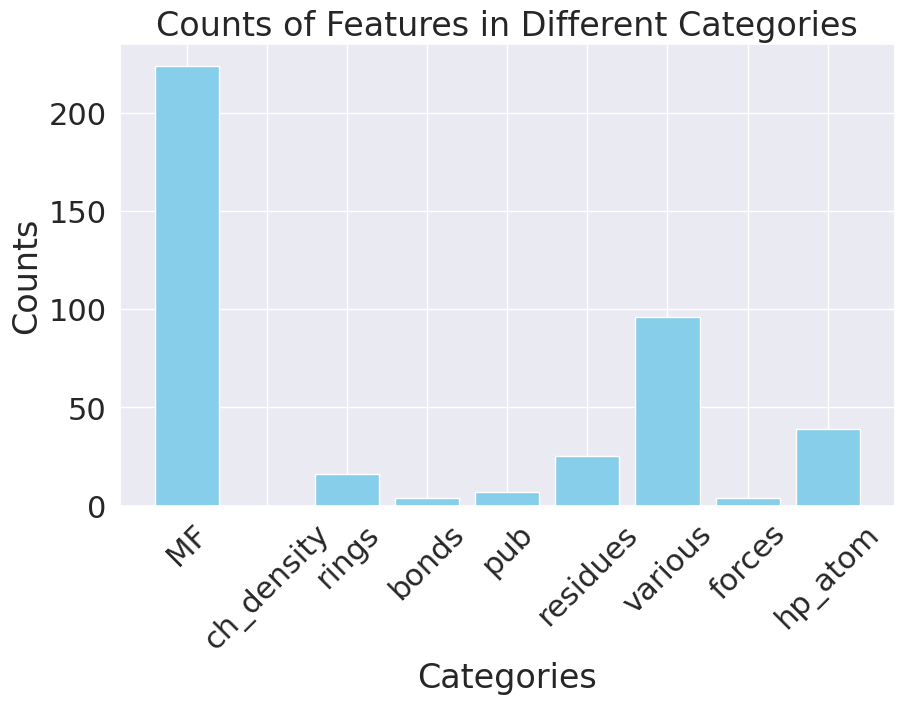

In [15]:

# Define the categories and their counts
categories = ['MF', 'ch_density', 'rings', 'bonds', 'pub', 'residues', 'various', 'forces', 'hp_atom']
counts = [len(MF)-800, len(ch_density), len(rings), len(bonds), len(pub), len(residues), len(various), len(forces), len(hp_atoms)]

# Create the histogram
plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color='skyblue')
plt.title('Counts of Features in Different Categories')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.show()


In [16]:
def identify_zero_columns(dataset, column_names):
    zero_columns = []
    for column_name in column_names:
        if (dataset[column_name] == 0).all():
            zero_columns.append(column_name)
    return zero_columns

def find_constant_features(df, feature_sets, threshold=0.90):
    """
    Identify features in a DataFrame that have a high fraction of constant values.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataset to analyze, where each row is an observation and each column is a feature.
    feature_sets : list of lists of str
        List of feature sets. Each inner list contains the names of the features to analyze.
    threshold : float, optional
        The fraction threshold above which a feature is considered to have a high fraction 
        of constant values (default is 0.90).

    Returns
    -------
    List[str]
        The list of feature names that have a fraction of constant values above the specified threshold.
    """
    constant_features = []
    for feature_set in feature_sets:
        features_to_check = [col for col in df.columns if col in feature_set]
        constant_features.extend([col for col in features_to_check if df[col].value_counts(normalize=True).max() > threshold])
    return constant_features


zeros_box = identify_zero_columns(df_stand, ch_density)
ch_density = [column for column in ch_density if column not in zeros_box]


zeros_rings = identify_zero_columns(df_stand, rings)
rings = [column for column in rings if column not in zeros_rings]

zeros_bonds = identify_zero_columns(df_stand, bonds)
bonds = [column for column in bonds if column not in zeros_bonds]


# Define your feature sets
feature_sets_to_check = [rings, bonds]

# Call the function with the desired feature sets
constant_features = find_constant_features(df_stand, feature_sets_to_check, threshold=0.999)  # Approximate to 1.0
# Remove constant features from rings and bonds
rings = [col for col in rings if col not in constant_features]
bonds = [col for col in bonds if col not in constant_features]


## CORE Feature Selection

- LASSO (linear + redundancy)

In [17]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
def select_features_with_lasso(x, target_series, correlated_variables, alpha=0.01):
    """
    Selects features using Lasso, excluding the bottom 10% unless they are in the correlated variables list.

    :param df: DataFrame with features only
    :param target_series: Series, the target variable
    :param correlated_variables: List of strings, names of correlated variables to potentially keep
    :param alpha: Regularization strength; must be a positive float. Larger values specify stronger regularization.
    :return: List of selected feature names
    """
    # Ensure the data is scaled
    #scaler = StandardScaler()
    #x = scaler.fit_transform(x)

    # Fit a Lasso model
    lasso = Lasso(alpha=alpha)
    lasso.fit(x, target_series)

    # Get the magnitude of coefficients
    coefficients = np.abs(lasso.coef_)
    feature_names = x.columns

    # Rank features by their coefficients
    ranked_features = sorted(zip(feature_names, coefficients), key=lambda x: x[1], reverse=True)

    # Identify bottom 10% features
    num_to_remove = int(len(ranked_features) * 0.1)
    features_to_remove = set([name for name, _ in ranked_features[-num_to_remove:]])

    # Check against correlated variables list and adjust the removal list
    features_to_remove = features_to_remove - set(correlated_variables)

    # Final feature list excludes the adjusted removal list
    final_features = [name for name, _ in ranked_features if name not in features_to_remove]

    return final_features


df_MF = df_stand[MF]
x = df_MF
MF_n = select_features_with_lasso(x, y, correlated_variables=correlated_variables)
print(MF_n)



df_hp = df_stand[hp_atoms]
x2 = df_hp
hp_n = select_features_with_lasso(x2, y, correlated_variables=correlated_variables)
print(hp_n)

['661', '666', '156', '389', '444', '257', '705', '407', '807', '650', '356', '880', '699', '428', '1', '314', '838', '734', '64', '4', '112', '90', '480', '935', '926', '219', '985', '724', '130', '816', '0', '2', '3', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '131', '132', '133', '13

In [18]:
feats_BCore =  MF_n+ch_density + rings + bonds + pub + residues + various + forces + hp_n + targets_f
df_stand2 = df_copy[feats_BCore]
df_stand2.head()

,661,666,156,389,444,257,705,407,807,650,...,hp_Atom_28,hp_Atom_29,hp_Atom_30,hp_Atom_31,hp_Atom_32,hp_Atom_33,hp_Atom_34,hp_Atom_35,Folder,QM/MM SP Barrier
0,0,0,1,0,1,0,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mol_134810,29.71
1,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mol_147462,28.33
2,0,0,0,0,0,0,0,0,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mol_22419,28.28
3,0,0,0,0,0,0,0,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mol_469,22.72
4,1,0,0,0,0,0,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mol_67286,25.81


In [19]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split

def feature_selection_insights(X, y, test_size=0.2, random_state=41):
    """
    Perform feature selection using Lasso and mutual information on the pre-scaled dataset.
    Manually splits the data and provides insights on selected and discarded features.

    Parameters:
    - X: pandas DataFrame, pre-scaled feature matrix.
    - y: pandas Series or array-like, target variable.
    - test_size: float, the proportion of the dataset to include in the test split.
    - random_state: int, controls the shuffling applied to the data before applying the split.

    Returns:
    - A dictionary with insights including features selected by each method and discarded by both.
    """

    # Splitting the dataset manually
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Enhancing LassoCV for a broader feature inclusion
    lasso = LassoCV(cv=4, random_state=random_state).fit(X_train, y_train)
    # Considering features with coefficients above a small threshold as relevant
    threshold = 1e-15  # Adjust this threshold as needed to include more features
    lasso_features = np.where(np.abs(lasso.coef_) > threshold)[0]

    # Calculating Mutual Information scores to determine feature relevance
    mi_scores = mutual_info_regression(X_train, y_train)
    # Expanding the selection to include more top features based on Mutual Information
    top_n = max(len(lasso_features), 20)  # Ensure at least 20 features, adjust as needed
    mi_features = np.argsort(mi_scores)[-top_n:]

    # Combining features selected by either method to minimize discarding
    combined_features = set(lasso_features).union(set(mi_features))

    # Identifying features not selected by either method (optional, for informational purposes)
    discarded_by_both = set(range(X.shape[1])) - combined_features


    # Insights
    insights = {
        'lasso_selected_features': [X.columns[i] for i in lasso_features],
        'mi_selected_features': [X.columns[i] for i in mi_features],
        'common_features': [X.columns[i] for i in combined_features],
        'discarded_by_both': [X.columns[i] for i in discarded_by_both]
    }

    # Adding counts for additional insights
    insights['num_features_lasso'] = len(lasso_features)
    insights['num_features_mi'] = len(mi_features)
    insights['num_common_features'] = len(combined_features)
    insights['num_discarded_by_both'] = len(discarded_by_both)

    return insights

In [20]:
x_Lmi_feats =  MF_n #ch_density + rings + bonds + pub + residues + various + forces 
y_Lmi_feats = 'QM/MM SP Barrier'
x_Lmi = df_stand[x_Lmi_feats]
y_Lmi = df_stand[y_Lmi_feats]
insights2 = feature_selection_insights(x_Lmi, df_stand[y_Lmi_feats], test_size=0.2, random_state=1)

In [21]:
filtered_MF = [x for x in MF_n if x not in insights2['discarded_by_both']]
print(filtered_MF)

['661', '666', '156', '389', '444', '705', '407', '807', '650', '356', '880', '699', '428', '1', '314', '838', '734', '64', '4', '112', '90', '480', '935', '926', '219', '985', '724', '130', '13', '33', '43', '52', '59', '61', '75', '77', '91', '101', '128', '138', '139', '148', '149', '167', '212', '214', '240', '250', '252', '276', '285', '288', '313', '322', '345', '387', '393', '429', '433', '440', '455', '456', '458', '464', '470', '481', '486', '487', '494', '540', '541', '549', '551', '560', '573', '578', '579', '583', '633', '638', '658', '674', '695', '698', '700', '726', '730', '741', '743', '774', '794', '802', '824', '832', '849', '875', '886', '891', '904', '920', '927', '932', '946', '967', '983', '1001', '1007', '1009', '1019']


In [22]:
x_Lmi_feats =  ch_density + rings + bonds + pub + residues + various + forces 
y_Lmi_feats = 'QM/MM SP Barrier'
x_Lmi = df_stand[x_Lmi_feats]
y_Lmi = df_stand[y_Lmi_feats]
insights = feature_selection_insights(x_Lmi, df_stand[y_Lmi_feats], test_size=0.2, random_state=41)

/home/juan/myenv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:664: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3703147860537683, tolerance: 0.5221878248184454
  model = cd_fast.enet_coordinate_descent_gram(


In [23]:
insights

{'lasso_selected_features': ['n7Ring',
  '5-Membered Heteroatom Rings',
  'pubchemhbonddonor',
  'pubchemrotbon',
  'pubchemmass',
  'resid 119',
  'saturated_carbocycles',
  'Box_13',
  'Box_26',
  'Box_33',
  'Box_34',
  'Box_46',
  'Box_49',
  'Box_51',
  'Total Charge',
  'internal_vdw_energy'],
 'mi_selected_features': ['resid 14',
  'uff_energy',
  'resid 119',
  'Box_38',
  'internal_vdw_energy',
  'Total Heteroatom Rings',
  'Weighted Electronegativity',
  'Box_30',
  'resid 30',
  'pubchemmass',
  'atom_number',
  'resid 146',
  'O',
  'pubchemrotbon',
  'pubchemhbondacceptor',
  'heavy_atoms',
  'pubchemlogp',
  'pubchemcomplexity',
  'pubchemtsa',
  'Total Charge'],
 'common_features': ['n7Ring',
  'Total Heteroatom Rings',
  '5-Membered Heteroatom Rings',
  'Box_13',
  'Total Charge',
  'uff_energy',
  'internal_vdw_energy',
  'pubchemhbonddonor',
  'pubchemrotbon',
  'pubchemhbondacceptor',
  'pubchemmass',
  'pubchemlogp',
  'pubchemcomplexity',
  'Box_26',
  'pubchemtsa'

In [24]:
import pandas as pd
import numpy as np

# Assuming df is your DataFrame

# Step 1: Find columns that start with "Box"
box_columns = [col for col in df_stand.columns if col.startswith('Box')]

# Step 2: Calculate a uniformity measure, such as variance, for these columns
uniformity_scores = df_stand[box_columns].var()

# Step 3: Identify the top 10% least uniform features to discard
num_to_discard = int(np.ceil(len(uniformity_scores) * 0.10))  # Calculate the number to discard (top 10%)
least_uniform_columns = uniformity_scores.nlargest(num_to_discard).index.tolist()

print(f"Columns to discard: {least_uniform_columns}")


Columns to discard: ['Box_7', 'Box_10', 'Box_17', 'Box_48', 'Box_53', 'Box_18', 'Box_41', 'Box_45']


In [32]:
def remove_features_from_lists(groups, features_to_remove):
    for group in groups:
        group[:] = [feature for feature in group if feature not in features_to_remove]
        
def create_dataframe_with_groups(df, groups):
    # Flatten the list of lists to get all features
    all_features = sum(groups, [])
    # Create a new DataFrame with the selected features
    new_df = df[all_features]
    return new_df

groups = [filtered_MF,ch_density, hp_n, rings, bonds, pub, residues, various, forces, targets_f]
# Remove features from each group
remove_features_from_lists(groups, insights['discarded_by_both'])


In [30]:
groups

[['661',
  '666',
  '156',
  '389',
  '444',
  '257',
  '705',
  '407',
  '807',
  '650',
  '356',
  '880',
  '699',
  '428',
  '1',
  '314',
  '838',
  '734',
  '64',
  '4',
  '112',
  '90',
  '480',
  '935',
  '926',
  '219',
  '985',
  '724',
  '130',
  '816',
  '0',
  '2',
  '3',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '19',
  '20',
  '21',
  '22',
  '23',
  '24',
  '25',
  '26',
  '27',
  '28',
  '29',
  '30',
  '31',
  '32',
  '33',
  '34',
  '35',
  '36',
  '37',
  '38',
  '39',
  '40',
  '41',
  '42',
  '43',
  '44',
  '45',
  '46',
  '47',
  '48',
  '49',
  '50',
  '51',
  '52',
  '53',
  '54',
  '55',
  '56',
  '57',
  '58',
  '59',
  '60',
  '61',
  '62',
  '63',
  '65',
  '66',
  '67',
  '68',
  '69',
  '70',
  '71',
  '72',
  '73',
  '74',
  '75',
  '76',
  '77',
  '78',
  '79',
  '80',
  '81',
  '82',
  '83',
  '84',
  '85',
  '86',
  '87',
  '88',
  '89',
  '91',
  '92',
  '93',
  '94',
  '95',
  '96',


In [33]:
df_small = create_dataframe_with_groups(df_copy, groups)

In [31]:
df_big = create_dataframe_with_groups(df_copy, groups)

In [35]:
df_big.head()

,661,666,156,389,444,257,705,407,807,650,...,Box_34,Box_38,Box_46,Box_49,Box_51,Total Charge,uff_energy,internal_vdw_energy,Folder,QM/MM SP Barrier
0,0,0,1,0,1,0,0,0,1,1,...,0.0,0.0,0.000000,0.0,-1.007604,1.000009,104.293073,2.925351,mol_134810,29.71
1,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,-0.056827,0.0,-0.183128,-0.000017,77.718378,-4.432160,mol_147462,28.33
2,0,0,0,0,0,0,0,0,1,2,...,0.0,0.0,-0.249862,0.0,0.000000,0.000008,94.836176,-5.104365,mol_22419,28.28
3,0,0,0,0,0,0,0,1,1,1,...,0.0,0.0,0.000000,0.0,0.819872,-0.000009,67.275734,-3.150597,mol_469,22.72
4,1,0,0,0,0,0,0,0,1,1,...,0.0,0.0,0.000000,0.0,-1.430314,0.999997,53.228547,-2.510429,mol_67286,25.81


In [34]:
df_small.head()

,661,666,156,389,444,705,407,807,650,356,...,Box_34,Box_38,Box_46,Box_49,Box_51,Total Charge,uff_energy,internal_vdw_energy,Folder,QM/MM SP Barrier
0,0,0,1,0,1,0,0,1,1,2,...,0.0,0.0,0.000000,0.0,-1.007604,1.000009,104.293073,2.925351,mol_134810,29.71
1,0,0,0,0,0,0,1,0,0,5,...,0.0,0.0,-0.056827,0.0,-0.183128,-0.000017,77.718378,-4.432160,mol_147462,28.33
2,0,0,0,0,0,0,0,1,2,4,...,0.0,0.0,-0.249862,0.0,0.000000,0.000008,94.836176,-5.104365,mol_22419,28.28
3,0,0,0,0,0,0,1,1,1,2,...,0.0,0.0,0.000000,0.0,0.819872,-0.000009,67.275734,-3.150597,mol_469,22.72
4,1,0,0,0,0,0,0,1,1,3,...,0.0,0.0,0.000000,0.0,-1.430314,0.999997,53.228547,-2.510429,mol_67286,25.81


final = df[merged_list]
new_order = list(final.columns.drop(['Folder', 'QM/MM SP Barrier'])) + ['Folder', 'QM/MM SP Barrier']
final = final.reindex(columns=new_order)
final.to_csv('/home/juan/Documents/Master_Project/data/process/final_selection/datasets_to_choose/data_med_low.csv')

In [33]:
filtered_df = df_copy[df_copy['QM/MM SP Barrier'] < 27]

filtered_df.reset_index(drop=True, inplace=True)

In [34]:
filtered_df.head()

,nBondsD,nBonds2,nBondsT,nBondsM,pubchemcomplexity,pubchemhbondacceptor,pubchemhbonddonor,pubchemrotbon,pubchemlogp,pubchemmass,...,hp_Atom_35,hp_Atom_36,hp_Atom_37,hp_Atom_38,Folder,QM/MM SP Barrier,uff_energy,internal_vdw_energy,torsion_energy,torsion_angle_energy
0,1,16,1,6,1.46888,6,0,6,1.46888,316.405,...,0.0,0.0,0.0,0.0,mol_469,22.72,67.275734,-3.150597,9.767127,4.792619
1,1,12,0,6,-0.04998,4,3,2,-0.04998,252.313,...,0.0,0.0,0.0,0.0,mol_67286,25.81,53.228547,-2.510429,24.631267,0.147438
2,1,15,0,12,2.29782,8,3,4,2.29782,360.393,...,0.0,0.0,0.0,0.0,mol_100593,22.70,106.460538,-1.405333,49.053102,0.000000
3,2,15,0,11,1.90260,7,2,6,1.90260,365.336,...,0.0,0.0,0.0,0.0,mol_27044,24.25,112.109042,-2.381642,31.487335,3.779126
4,2,13,0,12,1.18510,6,2,3,1.18510,338.411,...,0.0,0.0,0.0,0.0,mol_21168,26.80,79.263334,-2.866698,13.940592,2.600366


## Recursive Elimination

In [54]:

def manual_train_test_split(df, target_column, test_size=0.3, random_state=None):
    """
    Manually splits the DataFrame into training and testing sets at random.

    Parameters:
        df (DataFrame): The DataFrame containing the data to be split.
        target_column (str): The name of the target column.
        test_size (float or int): The proportion of the dataset to include in the test split.
            If float, should be between 0.0 and 1.0.
            If int, represents the absolute number of test samples.
        random_state (int or None): Random seed for reproducibility. Default is None.

    Returns:
        DataFrame: The training features (X_train).
        DataFrame: The testing features (X_test).
        Series: The training target (y_train).
        Series: The testing target (y_test).
    """
    # Set random seed for reproducibility
    if random_state is not None:
        np.random.seed(random_state)
    
    # Shuffle the indices of the DataFrame
    shuffled_indices = np.random.permutation(df.index)
    
    # Calculate the number of samples for the test set
    if isinstance(test_size, float):
        test_size = int(test_size * len(df))
    
    # Split the shuffled indices into training and testing indices
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    
    # Create the training and testing sets
    train_set = df.iloc[train_indices]
    test_set = df.iloc[test_indices]
    
    # Separate features (X) and target (y)
    X_train = train_set.drop(columns=[target_column, 'Folder'])
    y_train = train_set[target_column]
    X_test = test_set.drop(columns=[target_column, 'Folder'])
    y_test = test_set[target_column]
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = manual_train_test_split(df_big, target_column='QM/MM SP Barrier', test_size=0.3, random_state=42)

# Display shapes of X and y for train and test sets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (5991, 1060)
y_train shape: (5991,)
X_test shape: (2567, 1060)
y_test shape: (2567,)



def sigmoid(x, a=0.9, b=27):
    """
    Sigmoid-like function.

    Parameters:
    - x: Input value
    - a: Sigmoid parameter controlling the steepness of the curve
    - b: Sigmoid parameter controlling the horizontal shift of the curve

    Returns:
    - Sigmoid output value between 0 and 1
    """
    return  (1 / (1 + np.exp(a * (-x + b))))

In [53]:
def custom_weight(y):
    # Define your custom weight function here.
    # This example inversely weights the y values, giving higher weight to lower y values.
    return 1 / (y + 0.1)  # Adding a small constant to avoid division by zero for y=0

def weighted_mse(y_true, y_pred, weights):
    # Calculate the weighted mean squared error
    return np.mean(weights * (y_true - y_pred) ** 2)
true = 28 #2 and 5
pred = 33
a = custom_weight(true)
b = weighted_mse(true, pred, a)
print(b)

0.889679715302491


0.165   1.037

In [55]:

from sklearn.ensemble import RandomForestRegressor

def selectiveRF(X_train, y_train, X_test, y_test, tol=0.0001, max_depth=None, top_n=15, n_estimators=300, min_samples_split=3, min_samples_leaf=3, random_state=42):
    features_to_remove = []
    count = 1
    weights_train = custom_weight(y_train)
    weights_test = custom_weight(y_test)

    # Initial model using all the features
    model_all_features = RandomForestRegressor(n_estimators=n_estimators, criterion="squared_error", max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=0.4, bootstrap=True, oob_score=True, n_jobs=-1, random_state=random_state)
    model_all_features.fit(X_train, y_train)
    y_pred_test = model_all_features.predict(X_test)
    mean_sqr_all = weighted_mse(y_test, y_pred_test, weights_test)

    for feature in X_train.columns:
        print('\ntesting feature: ', feature, ' which is feature ', count, ' out of ', len(X_train.columns))
        count += 1
        model = RandomForestRegressor(n_estimators=n_estimators, criterion="squared_error", max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=0.4, bootstrap=True, oob_score=True, n_jobs=-1, random_state=random_state)

        # Fit model with all variables minus the removed features and the feature to be evaluated
        model.fit(X_train.drop(features_to_remove + [feature], axis=1), y_train)
        y_pred_test = model.predict(X_test.drop(features_to_remove + [feature], axis=1))
        mean_sqr = weighted_mse(y_test, y_pred_test, weights_test)
        print('New Test MSE={}'.format(mean_sqr))

        # Print the original mse with all the features
        print('All features Test MSE={}'.format(mean_sqr_all))

        # Determine the drop in the mse
        diff_mse = mean_sqr_all - mean_sqr
        print(diff_mse)
        if diff_mse >= tol:
            print('Drop in MSE={}'.format(diff_mse))
            print('keep: ', feature)
        else:
            print('Drop in MSE={}'.format(diff_mse))
            print('remove: ', feature)
            mean_sqr_all = mean_sqr  # Correct typo here
            features_to_remove.append(feature)

    print('DONE!!\ntotal features to remove: ', len(features_to_remove))
    features_to_keep = [x for x in X_train.columns if x not in features_to_remove]
    print('total features to keep: ', len(features_to_keep))

    return features_to_keep, features_to_remove


feats_rec, feat_remove =selectiveRF(X_train,y_train,X_test,y_test,
                                     tol=0.005,max_depth=50,
                                     top_n=15,n_estimators=8
                                     00, min_samples_split= 3, min_samples_leaf=3, random_state=42)
    


testing feature:  661  which is feature  1  out of  1060
New Test MSE=0.11373312568753062
All features Test MSE=0.11359374135069443
-0.00013938433683619023
Drop in MSE=-0.00013938433683619023
remove:  661

testing feature:  666  which is feature  2  out of  1060
New Test MSE=0.11373105371410368
All features Test MSE=0.11373312568753062
2.0719734269425416e-06
Drop in MSE=2.0719734269425416e-06
remove:  666

testing feature:  156  which is feature  3  out of  1060
New Test MSE=0.1137603274473667
All features Test MSE=0.11373105371410368
-2.9273733263016077e-05
Drop in MSE=-2.9273733263016077e-05
remove:  156

testing feature:  389  which is feature  4  out of  1060
New Test MSE=0.11378592264393651
All features Test MSE=0.1137603274473667
-2.5595196569819234e-05
Drop in MSE=-2.5595196569819234e-05
remove:  389

testing feature:  444  which is feature  5  out of  1060
New Test MSE=0.11386887610872236
All features Test MSE=0.11378592264393651
-8.295346478584542e-05
Drop in MSE=-8.295346478

KeyboardInterrupt: 

In [42]:
feats_rec

['nBondsD', '0', '35', '57', '60', '61', '117', '160', '1004', '1023']

In [37]:
new_df.head()

,661,666,156,389,444,257,705,407,807,650,...,Box_33,Box_34,Box_46,Box_49,Box_51,Box_75,Total Charge,internal_vdw_energy,Folder,QM/MM SP Barrier
0,0,0,1,0,1,0,0,0,1,1,...,0.0,0.0,0.000000,0.0,-1.007604,0.0,1.000009,2.925351,mol_134810,29.71
1,0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,-0.056827,0.0,-0.183128,0.0,-0.000017,-4.432160,mol_147462,28.33
2,0,0,0,0,0,0,0,0,1,2,...,0.0,0.0,-0.249862,0.0,0.000000,0.0,0.000008,-5.104365,mol_22419,28.28
3,0,0,0,0,0,0,0,1,1,1,...,0.0,0.0,0.000000,0.0,0.819872,0.0,-0.000009,-3.150597,mol_469,22.72
4,1,0,0,0,0,0,0,0,1,1,...,0.0,0.0,0.000000,0.0,-1.430314,0.0,0.999997,-2.510429,mol_67286,25.81


In [56]:
merged_list = list(set(new_df.columns.tolist() + feats_rec))  # Remove duplicates and combine columns
merged_list.remove('Folder')  # Remove 'Folder' from the list
merged_list.remove('QM/MM SP Barrier')  # Remove 'QM/MM SP Barrier' from the list
merged_list += ['Folder', 'QM/MM SP Barrier']  # Append 'Folder' and 'QM/MM SP Barrier' to the end


In [57]:
merged_list

['hp_Atom_0',
 '926',
 'heavy_atoms',
 '724',
 '444',
 '824',
 '891',
 '1019',
 '458',
 'hp_Atom_13',
 '343',
 '276',
 '0',
 'hp_Atom_15',
 'Total Charge',
 '86',
 '516',
 '39',
 '184',
 '661',
 '344',
 '734',
 '374',
 'hp_Atom_16',
 '480',
 '462',
 '156',
 '117',
 '600',
 'hp_Atom_27',
 '250',
 '360',
 'Box_30',
 '880',
 '331',
 '1',
 '726',
 'hp_Atom_25',
 '927',
 '1023',
 '138',
 'hp_Atom_1',
 'hp_Atom_24',
 'nBondsD',
 '57',
 '463',
 '425',
 '76',
 '914',
 '932',
 'hp_Atom_22',
 '1004',
 'n7Ring',
 '128',
 '429',
 '698',
 'resid 30',
 'pubchemhbondacceptor',
 '214',
 '849',
 'F',
 'Box_33',
 'hp_Atom_19',
 '807',
 '730',
 'pubchemtsa',
 '1001',
 'Box_49',
 '739',
 'pubchemrotbon',
 '440',
 '674',
 '251',
 '257',
 'hp_Atom_6',
 '540',
 '13',
 '695',
 '983',
 'hp_Atom_28',
 'hp_Atom_5',
 'amide_bonds',
 '523',
 '820',
 'hp_Atom_29',
 '322',
 '35',
 '259',
 '705',
 '985',
 '61',
 '700',
 '160',
 '356',
 'hp_Atom_18',
 '325',
 '747',
 'hp_Atom_26',
 'hp_Atom_20',
 '946',
 '5-Membered H

In [59]:
final_df = df_copy[merged_list]
final_df.to_csv('/home/juan/Documents/Master_Project/data/process/final_selection/datasets_to_choose/data_1_test.csv')

In [48]:
df_copy

,nBondsD,nBonds2,nBondsT,nBondsM,pubchemcomplexity,pubchemhbondacceptor,pubchemhbonddonor,pubchemrotbon,pubchemlogp,pubchemmass,...,hp_Atom_35,hp_Atom_36,hp_Atom_37,hp_Atom_38,Folder,QM/MM SP Barrier,uff_energy,internal_vdw_energy,torsion_energy,torsion_angle_energy
0,1,11,0,11,0.39820,5,2,4,0.39820,285.371,...,0.0,0.0,0.0,0.0,mol_134810,29.71,104.293073,2.925351,12.268261,1.176219
1,0,14,0,12,3.35790,4,0,3,3.35790,309.413,...,0.0,0.0,0.0,0.0,mol_147462,28.33,77.718378,-4.432160,21.626627,0.178048
2,2,14,0,11,1.79150,6,1,7,1.79150,340.427,...,0.0,0.0,0.0,0.0,mol_22419,28.28,94.836176,-5.104365,6.601106,8.052565
3,1,16,1,6,1.46888,6,0,6,1.46888,316.405,...,0.0,0.0,0.0,0.0,mol_469,22.72,67.275734,-3.150597,9.767127,4.792619
4,1,12,0,6,-0.04998,4,3,2,-0.04998,252.313,...,0.0,0.0,0.0,0.0,mol_67286,25.81,53.228547,-2.510429,24.631267,0.147438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8553,0,14,0,11,-0.45050,7,2,2,-0.45050,300.390,...,0.0,0.0,0.0,0.0,mol_74738,27.96,111.801088,-2.893928,15.258133,0.589026
8554,3,14,0,11,0.31220,9,3,5,0.31220,356.386,...,0.0,0.0,0.0,0.0,mol_167556,26.87,140.441243,-0.417118,38.404353,0.151933
8555,1,13,0,12,2.58562,5,1,2,2.58562,329.375,...,0.0,0.0,0.0,0.0,mol_11130,29.66,80.020623,-4.326108,32.411730,0.000000
8556,2,13,0,11,1.40882,7,2,2,1.40882,328.372,...,0.0,0.0,0.0,0.0,mol_83650,28.09,118.348335,-4.217139,32.109134,0.000000


In [89]:
new_df[feats_rec + ['Folder', 'QM/MM SP Barrier']].to_csv('/home/juan/Documents/Master_Project/data/interim/test_for_low.csv')

In [132]:
file_path = '/home/juan/Documents/Master_Project/data/features_list/rf-f-0.00001.txt'

# Open the file in read mode
with open(file_path, 'r') as file:
    # Read all lines from the file
    lines = file.readlines()
    
# Remove the '\n' from the valid feature names
valid_feature_names = [name.replace('\n', '') for name in lines]


In [133]:
filtered_list1 = [x for x in feats_rec if (x.isdigit() or not x.isdigit()) and x not in valid_feature_names]
print(len(filtered_list1))


459


In [77]:
import re
# Define a function to check if a string contains only numeric characters
def is_numeric(s):
    return bool(re.match(r'^[0-9]+$', s))


# Filter out columns not present in valid_feature_names
filtered_columns = [col for col in new_df.columns if col in feats_rec or not is_numeric(col)]
print(filtered_columns)
filtered_dataset = new_df[filtered_columns]


['661', '666', '156', '389', '444', '257', '407', '807', '650', '356', '880', '699', '428', '1', '314', '838', '734', '64', '4', '112', '90', '480', '935', '926', '985', '724', '816', '0', '2', '3', '5', '6', '7', '8', '9', '10', '11', '12', '13', '15', '16', '17', '19', '20', '21', '22', '23', '24', '25', '26', '28', '29', '30', '31', '32', '33', '34', '36', '37', '38', '39', '40', '180', '206', '210', '211', '214', '216', '218', '221', '222', '223', '224', '225', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '242', '243', '244', '246', '248', '254', '260', '261', '262', '263', '265', '266', '268', '270', '280', '284', '285', '289', '291', '293', '294', '295', '298', '299', '300', '301', '302', '303', '304', '306', '308', '309', '311', '312', '313', '315', '317', '318', '320', '323', '324', '325', '327', '328', '329', '334', '335', '336', '337', '338', '339', '340', '341', '343', '344', '345', '347', '348', '352', '353', '354', '355', '357'

In [187]:

dataset_initial = pd.read_csv('/home/juan/Documents/Master_Project/data/process/initial/dataset.csv')
df = dataset_initial.iloc[:,1:]
data_all = pd.read_csv('/home/juan/Documents/Master_Project/data/process/dataset_ext_ALLB.csv')

filtered_dataset2 = data_all[df.columns]


In [8]:
#final_df = new_df[filtered_list1 + ['Folder', 'QM/MM SP Barrier']]
#final_df.head()
import pandas as pd
final_df= pd.read_csv('/home/juan/Documents/Master_Project/data/process/final_selection/datasets_to_choose/data4.csv')
final_df=final_df.iloc[:,1:]

In [95]:
dataset_initial = pd.read_csv('/home/juan/Documents/Master_Project/data/process/initial/dataset.csv')
df = dataset_initial.iloc[:,1:]
data_all = pd.read_csv('/home/juan/Documents/Master_Project/data/process/dataset_ext_ALLB.csv')
df = data_all[df.columns]

In [8]:

new_df.head()

,nBondsD,nBonds2,nBondsT,nBondsM,pubchemcomplexity,pubchemhbondacceptor,pubchemhbonddonor,pubchemrotbon,pubchemlogp,pubchemmass,...,hp_Atom_31,hp_Atom_32,hp_Atom_33,hp_Atom_34,hp_Atom_35,hp_Atom_36,hp_Atom_37,hp_Atom_38,Folder,QM/MM SP Barrier
0,1,11,0,11,0.39820,5,2,4,0.39820,285.371,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mol_134810,29.71
1,0,14,0,12,3.35790,4,0,3,3.35790,309.413,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mol_147462,28.33
2,2,14,0,11,1.79150,6,1,7,1.79150,340.427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mol_22419,28.28
3,1,16,1,6,1.46888,6,0,6,1.46888,316.405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mol_469,22.72
4,1,12,0,6,-0.04998,4,3,2,-0.04998,252.313,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mol_67286,25.81


In [88]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets
X = final.drop(columns=['QM/MM SP Barrier', 'Folder']) #,'327', '328', '329', '334', '335', '336', '337', '338', '339', '340', '341', '343', '344', '345'])  # Features
y = final['QM/MM SP Barrier']  # Target variable

# Standardize features (X) and target variable (y)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).ravel()
print(X_scaled.shape)

(8558, 96)


Function execution time: 21.617104530334473 seconds


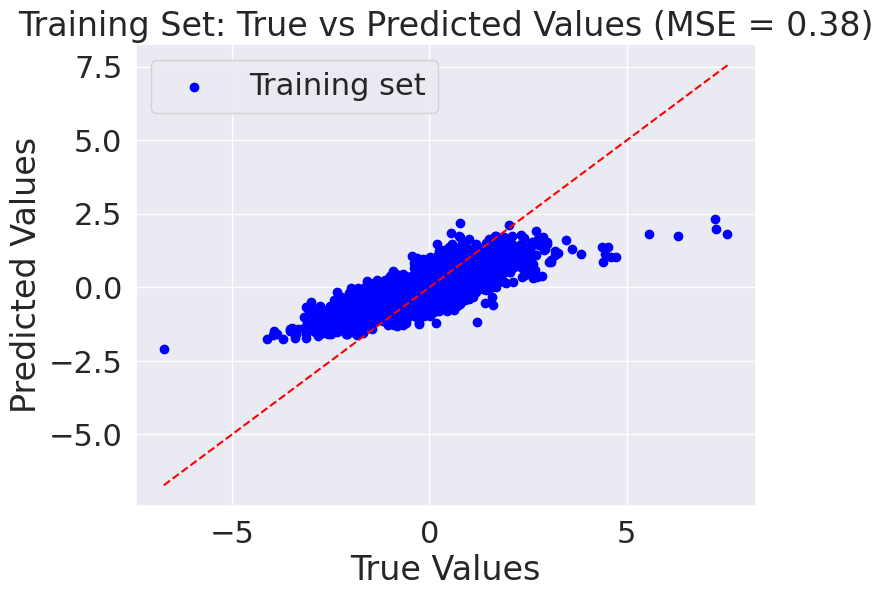

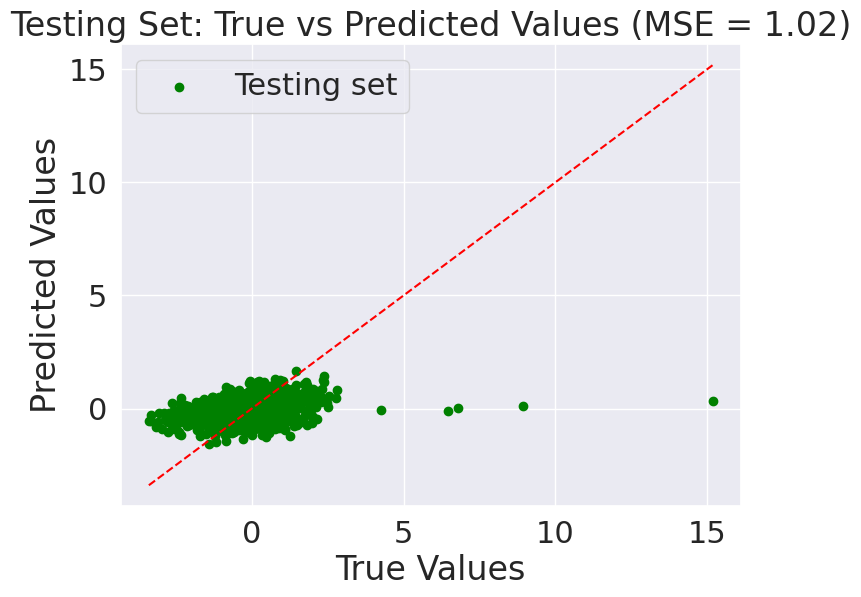

In [89]:
import time
def manual_train_test_split(X, y, test_size=0.2, random_state=None):
    """
    Manually splits the dataset into training and testing sets.

    Parameters:
        X (array-like): The feature matrix.
        y (array-like): The target variable.
        test_size (float or int): The proportion of the dataset to include in the test split.
            If float, should be between 0.0 and 1.0.
            If int, represents the absolute number of test samples.
        random_state (int or None): Random seed for reproducibility. Default is None.

    Returns:
        array-like: The training features (X_train).
        array-like: The testing features (X_test).
        array-like: The training target (y_train).
        array-like: The testing target (y_test).
    """
    # Set random seed for reproducibility
    if random_state is not None:
        np.random.seed(random_state)
    
    # Shuffle the indices of the dataset
    n_samples = len(X)
    shuffled_indices = np.random.permutation(n_samples)
    
    # Calculate the number of samples for the test set
    if isinstance(test_size, float):
        test_size = int(test_size * n_samples)
    
    # Split the shuffled indices into training and testing indices
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    
    # Create the training and testing sets
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    return X_train, X_test, y_train, y_test

# Example usage
# Assuming X and y are your feature matrix and target variable, respectively
X_train, X_test, y_train, y_test = manual_train_test_split(X_scaled, y_scaled, test_size=0.18, random_state=21)

# Train a Random Forest regressor
rf_model = RandomForestRegressor(n_estimators=9900, max_features='sqrt', max_depth=100, 
                                      min_samples_split=3, min_samples_leaf=3, bootstrap=True, 
                                      n_jobs=20, verbose=0, warm_start=True)

rf_regressor = RandomForestRegressor(
    n_estimators=9000,
    criterion="squared_error",
    max_depth=50,
    min_samples_split=3,
    min_samples_leaf=3,
    max_features=0.4,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42,
    ccp_alpha=0.0,
    max_samples=None,
    monotonic_cst=None)
start_time = time.time()

rf_regressor.fit(X_train, y_train)

# Make predictions on training and testing sets
y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

# Record the end time
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print("Function execution time:", elapsed_time, "seconds")
# Calculate mean squared error
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# Plot training set
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred, color='blue', label='Training set')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Training Set: True vs Predicted Values (MSE = {:.2f})'.format(train_mse))
plt.legend()
plt.grid(True)
plt.show()

# Plot testing set
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='green', label='Testing set')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Testing Set: True vs Predicted Values (MSE = {:.2f})'.format(test_mse))
plt.legend()
plt.grid(True)
plt.show()

45.5 s 600
15.3 s 200


 Define the parameter grid
param_grid = {
    'ccp_alpha': [0.0, 0.01, 0.1],  # Example values; adjust based on preliminary results
    'max_samples': [0.5, 0.75, 1.0]  # Fraction of samples
}

 Initialize the regressor
regressor = RandomForestRegressor(n_estimators=100, random_state=42)

 Initialize GridSearchCV
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

 Fit GridSearchCV
grid_search.fit(X_train, y_train)

 Best parameters
print("Best parameters:", grid_search.best_params_)

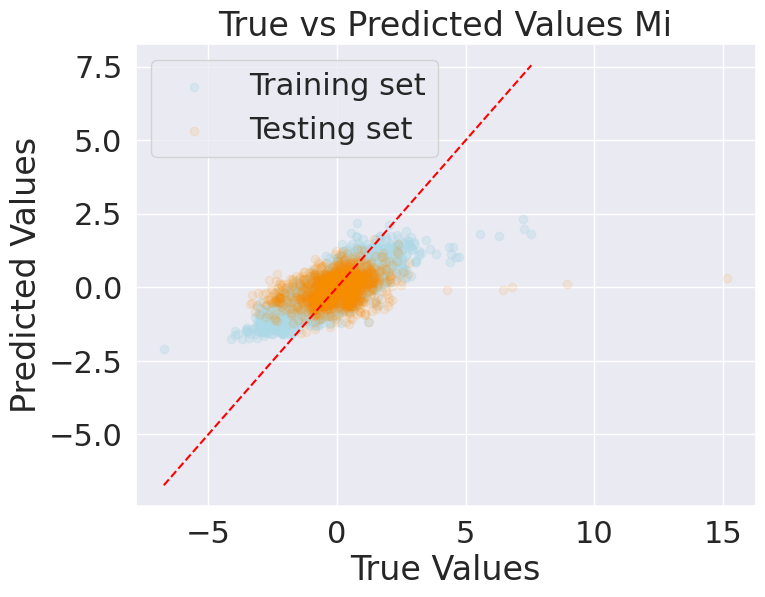

In [90]:
import matplotlib.pyplot as plt

# Plot both training and testing sets on one plot
plt.figure(figsize=(8, 6))

# Plot training set

plt.scatter(y_train, y_train_pred, color='lightblue', label='Training set', alpha=0.3)

# Plot testing set
plt.scatter(y_test, y_test_pred, color='darkorange', label='Testing set', alpha=0.1)

# Plot diagonal line
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')

# Labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values Mi')
plt.legend()
plt.grid(True)
plt.show()


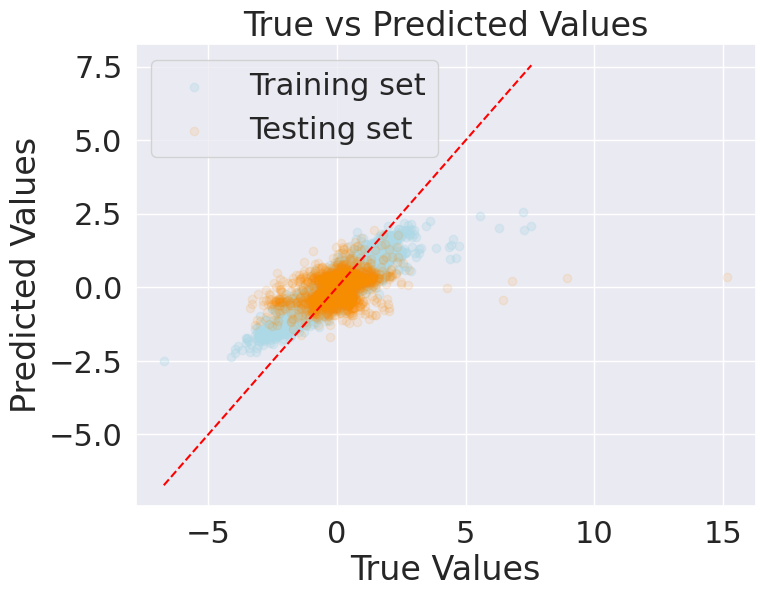

In [85]:
import matplotlib.pyplot as plt

# Plot both training and testing sets on one plot
plt.figure(figsize=(8, 6))

# Plot training set

plt.scatter(y_train, y_train_pred, color='lightblue', label='Training set', alpha=0.3)

# Plot testing set
plt.scatter(y_test, y_test_pred, color='darkorange', label='Testing set', alpha=0.1)

# Plot diagonal line
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')

# Labels and title
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


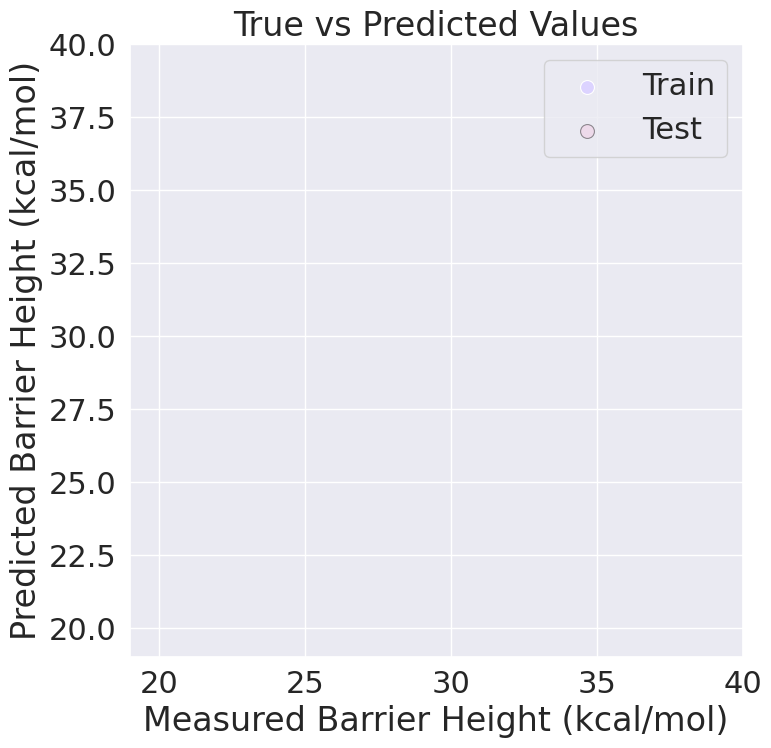

In [82]:
from sklearn.preprocessing import StandardScaler

# Unstandardize predictions
y_train_pred_unscaled = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).ravel()
y_test_pred_unscaled = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).ravel()

# Unstandardize true values
y_train_unscaled = scaler_y.inverse_transform(y_train.reshape(-1, 1)).ravel()
y_test_unscaled = scaler_y.inverse_transform(y_test.reshape(-1, 1)).ravel()
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming the unscaled data is stored in y_train_unscaled, y_train_pred_unscaled, y_test_unscaled, y_test_pred_unscaled
# And that you've calculated the scores for the train and test sets, stored in train_score and test_score

train_score = 0.28  # Replace with actual score
test_score = 0.90   # Replace with actual score
data_train = pd.DataFrame({
    'Measured Barrier Height': y_train_unscaled,
    'Predicted Barrier Height': y_train_pred_unscaled,
    'Set': 'Train'
})
data_test = pd.DataFrame({
    'Measured Barrier Height': y_test_unscaled,
    'Predicted Barrier Height': y_test_pred_unscaled,
    'Set': 'Test'
})

# Combine the two DataFrames into one for plotting
data_combined = pd.concat([data_train, data_test])

# Define the figure and axes
plt.figure(figsize=(10, 8))

# Create the Seaborn scatter plot for the training data
sns.scatterplot(data=data_combined[data_combined['Set'] == 'Train'],
                x='Measured Barrier Height', y='Predicted Barrier Height',
                color='#DCD3FF',  # A pastel-like color
                label='Train', s=100)

# Create the Seaborn scatter plot for the testing data
sns.scatterplot(data=data_combined[data_combined['Set'] == 'Test'],
                x='Measured Barrier Height', y='Predicted Barrier Height',
                color='#F2C2E0',  # A pastel-like color
                label='Test', s=100, alpha=0.4, edgecolor='black')  # Black edges and more transparency
plt.plot([min(y_train_unscaled), max(y_train_unscaled)], [min(y_train_unscaled), max(y_train_unscaled)], color='#708090', linestyle='--')
# Set labels and title
plt.xlabel('Measured Barrier Height (kcal/mol)')
plt.ylabel('Predicted Barrier Height (kcal/mol)')
plt.title('True vs Predicted Values')
plt.xlim(19,40)
plt.ylim(19,40)
# Ensure the aspect ratio is equal to make the plot square
plt.gca().set_aspect('equal', 'box')

# Add grid
plt.grid(True)

# Show the plot
plt.legend()
plt.tight_layout()
plt.show()




In [62]:
sns.color_palette("pastel2")

ValueError: 'pastel2' is not a valid palette name

In [192]:
pe = pearsonr(y_test_unscaled, y_test_pred_unscaled)[0]
print(pe)

0.40411385654669807


In [ ]:
0.386